<a href="https://colab.research.google.com/github/pablojrios/fluence_maps/blob/master/tf2_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compute predictions on a TF dataset using an stored .h5 model

In [213]:
def isGoogleColab():
    # 'ipykernel.zmqshell' runs in our server
    # 'google.colab._shell' runs in Google Colab
    return get_ipython().__class__.__module__ == 'google.colab._shell'

In [214]:
import numpy as np
import tensorflow as tf
from util.dataset import _tfrecord_dataset_type_from_folder, _parse_jpeg_image_function
from util.preprocess import rescale_0_to_1
import os
import pandas as pd
# Es indistinto usar las métricas de scikit learn o tensorflow
# from sklearn.metrics import mean_absolute_error
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib import pyplot as plt

In [215]:
print('Tensorflow version = {}'.format(tf.__version__))
print('Executing eagerly = {}'.format(tf.executing_eagerly()))

Tensorflow version = 2.2.0
Executing eagerly = True


In [216]:
#%cd /content/drive/My\ Drive/Healthcare/Radioterapia/data/ciolaplata
#!unrar x /content/drive/My\ Drive/Healthcare/Radioterapia/Mapas\ CIO\ La\ Plata/Mapas\ Calculados/2019.rar
#!ls -l 2015/*dcm | wc -l

if isGoogleColab():
    %cd -q '/content'
    if os.path.exists('fluence_maps'):
        !rm -fr fluence_maps

    GIT_USERNAME = "pablojrios"
    GIT_TOKEN = "1d88a0b85d2b00a03796e4d8b7e5f7b249b12f9b"
    !git clone -s https://{GIT_TOKEN}@github.com/{GIT_USERNAME}/fluence_maps.git

    from google.colab import drive
    drive.mount('/content/drive')
    
    !ls -l '/content/drive/My Drive/Healthcare/Radioterapia/data/ciolaplata/models'
    
    ARG_DATASET_DIR='/content/drive/My Drive/Healthcare/Radioterapia/data/ciolaplata'

In [217]:
#============================DEFINE YOUR ARGUMENTS==============================
if not isGoogleColab():
    # base data directory
    ARG_DATASET_DIR='/hdd/data/radioterapia/ciolaplata'
# folder under ARG_DATASET_DIR path.
ARG_TFDATASET_FOLDER='tfds-2019-localnorm-113355'
ARG_MODEL_NAME = '1611181203' # VGG16 20 de enero 2021
# ARG_MODEL_NAME = '1611181684' # ResNet 18 20 de enero 2021
# 'train', 'validation', 'test' 
ARG_PART = 'validation'
ARG_TRANSFORM_GAMMA=False

In [218]:
tfdataset_dir = os.path.join(ARG_DATASET_DIR, ARG_TFDATASET_FOLDER)
raw_test = _tfrecord_dataset_type_from_folder(tfdataset_dir, ARG_PART)
print(raw_test)

<TFRecordDatasetV2 shapes: (), types: tf.string>


In [219]:
# Apply this function to each item in the dataset using the map method:
num_workers = 8
IMG_SIZE = 256
normalization_fn = rescale_0_to_1
test = raw_test.map(lambda e: _parse_jpeg_image_function(e, IMG_SIZE, normalization_fn, transform_gamma=ARG_TRANSFORM_GAMMA), num_parallel_calls=num_workers)
print(test)

<ParallelMapDataset shapes: ((256, 256, 3), (), ()), types: (tf.float32, tf.float32, tf.string)>


In [220]:
gamma_values = test.map(lambda image, gamma, filename: gamma)
gamma_values = np.array(list(gamma_values.as_numpy_iterator()))
BATCH_SIZE = 32 # mae puede variar según batch size.
test_batches = test.batch(BATCH_SIZE)
print(test_batches)

<BatchDataset shapes: ((None, 256, 256, 3), (None,), (None,)), types: (tf.float32, tf.float32, tf.string)>


In [221]:
gamma_values

array([ 94.9713  ,  99.65418 ,  95.1143  ,  99.56485 ,  99.81494 ,
        86.9148  ,  96.6144  ,  96.2427  ,  99.46195 ,  99.01814 ,
        99.75241 ,  97.9429  ,  99.15427 ,  97.4026  ,  98.9906  ,
        99.77383 ,  97.0141  ,  99.66353 ,  97.1984  ,  99.57138 ,
        99.06374 ,  92.481   ,  97.563   ,  99.17148 ,  98.6501  ,
        98.9895  ,  99.10782 ,  98.9747  ,  99.86622 ,  98.7738  ,
        96.5368  ,  98.6483  ,  94.8744  ,  99.18528 ,  95.5027  ,
        98.5017  ,  97.1651  ,  95.5868  ,  99.930824,  97.6473  ,
        99.18165 ,  98.0019  ,  98.7342  ,  99.85006 ,  98.9628  ,
        98.6337  ,  98.8599  ,  99.944275,  99.56468 ,  99.74794 ,
        99.42905 ,  97.7609  ,  99.83155 ,  99.33907 , 100.      ,
        99.6061  ,  99.35998 ,  97.7755  ,  98.9677  ,  99.67603 ,
        95.7748  ,  98.6577  ,  91.2326  ,  99.69118 ,  99.92806 ,
        98.3503  ,  99.58792 ,  98.608   ,  96.8416  ,  99.74189 ,
        99.67704 ,  98.6064  ,  95.225   ,  98.3013  ,  97.762

In [222]:
# load model
dir = os.path.join(ARG_DATASET_DIR, "models")
saved_model_dir = '{}/{}.h5'.format(dir, ARG_MODEL_NAME)
print(f'Loading model {saved_model_dir}...')
loaded_model = tf.keras.models.load_model(saved_model_dir)

Loading model /hdd/data/radioterapia/ciolaplata/models/1611181203.h5...


In [223]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 14,977,857
Trainable params: 12,062,209
Non-trainable params: 2,915,648
_________________________________________________________________


In [224]:
# Evaluate dataset with the loaded model to calculate loss (mae) because
# metric value could differ from the one reported during training.
tmp_test_batches = test_batches.map(lambda image, gamma, filename: (image, gamma))
print(tmp_test_batches)
loss, mse = loaded_model.evaluate(tmp_test_batches, workers=num_workers, verbose=0)
print('\n\nLoaded model, test loss: {:5.4f}'.format(loss))
print('Loaded model, test mse: {:5.4f}'.format(mse))

<MapDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.float32)>


Loaded model, test loss: 1.2123
Loaded model, test mse: 7.1444


In [225]:
# For VGG16 only
inputs=loaded_model.get_layer("vgg16").input
outputs=loaded_model.get_layer("vgg16").output
cnn_part=tf.keras.models.Model(inputs, outputs)
cnn_part.summary()
predictions = cnn_part.predict(tmp_test_batches)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0  

In [226]:
# For VGG16 only
predictions[0][:,:,3].mean()

0.19321111

In [227]:
# For VGG16 only
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(predictions)
extracted_features = feature_batch_average.numpy()
extracted_features[0]

array([1.88282073e-01, 0.00000000e+00, 4.72093284e-01, 1.93211064e-01,
       1.92909196e-01, 0.00000000e+00, 0.00000000e+00, 4.70261760e-02,
       1.05517074e-01, 1.46554977e-01, 0.00000000e+00, 0.00000000e+00,
       2.32034311e-01, 0.00000000e+00, 0.00000000e+00, 4.22584563e-01,
       0.00000000e+00, 3.12842697e-01, 0.00000000e+00, 0.00000000e+00,
       6.71683177e-02, 5.34275314e-03, 1.64704397e-05, 1.58349440e-01,
       1.87831819e-01, 0.00000000e+00, 2.75788218e-01, 4.47381334e-03,
       2.51790643e-01, 6.03195745e-04, 1.54512733e-01, 1.41264349e-01,
       2.16727003e-01, 2.54873991e-01, 3.65392148e-01, 0.00000000e+00,
       4.46579814e-01, 1.19189720e-03, 0.00000000e+00, 0.00000000e+00,
       1.45695424e-02, 0.00000000e+00, 5.29043794e-01, 8.75004660e-03,
       0.00000000e+00, 1.88799620e-01, 1.84669485e-03, 1.12335190e-01,
       0.00000000e+00, 2.31538773e-01, 4.27118689e-02, 0.00000000e+00,
       1.13562174e-01, 1.65948528e-03, 1.06575154e-03, 7.68699229e-01,
      

In [228]:
# For VGG16 only
from math import isclose
a=predictions[0][:,:,3].mean()
b=extracted_features[0][3]
isclose(a, b, rel_tol=1e-6)

True

In [229]:
extracted_features.shape

(244, 512)

In [230]:
# Make predictions
predictions = loaded_model.predict(tmp_test_batches)
# from (1121,1) to (1121,); ie.: ndim = 2 to ndim = 1
predictions = predictions.reshape(-1)
predictions.shape

(244,)

In [231]:
tmp_test_batches = test.map(lambda image, gamma, filename: (filename, gamma))
lst = [(filename.numpy().decode('utf-8'), gamma.numpy()) for filename, gamma in tmp_test_batches]
lst2 = [(e[0], e[1], p) for e, p in zip(lst, predictions)]

# armar un pandas dataframe con el test set completo
df = pd.DataFrame(lst2, columns=['filename', 'actual gamma', 'predicted gamma'])
dir = os.path.join(ARG_DATASET_DIR, "predictions")
predictions_file_path = '{}/predicted_gamma_{}.{}.csv'.format(dir, ARG_MODEL_NAME, ARG_PART)
df.to_csv(predictions_file_path, index=False)
print(f'Predictions saved to {predictions_file_path}.')

Predictions saved to /hdd/data/radioterapia/ciolaplata/predictions/predicted_gamma_1611181203.validation.csv.


In [232]:
def display_scatterplot(part, y, y_hat):
    # mean average error
    mae = mean_absolute_error(y, y_hat)
    print('MAE on %s = %.3f' % (part, mae))

    # correlación entre predichos y observados
    corr = np.corrcoef(y, y_hat)[0,1]
    print('Corr. actual vs predicted = %.3f' % corr)

    r2score = r2_score(y, y_hat)
    print('R^2 = %.3f' % r2score)
    
    # plot calculados vs. predichos (targets)
    fig_dims = (8, 8)
    fig, ax = plt.subplots(figsize=fig_dims)
    plt.title('Actual vs. Predicted (%s)' % part)
    plt.gca().set_aspect('equal')
    sns.scatterplot(y, y_hat, marker='o', ax=ax)
    ax.set(xlabel="Actual", ylabel = "Predicted")
    plt.figure(figsize=(15, 15))
    minimum = int(np.min([y.min(), y_hat.min()]))
    ax.set_xlim([minimum, 100])
    ax.set_ylim([minimum, 100])
    ax.plot([minimum, 100], [minimum, 100], ls="--", c=".7")
    plt.show()

MAE on validation = 1.212
Corr. actual vs predicted = 0.500
R^2 = 0.223


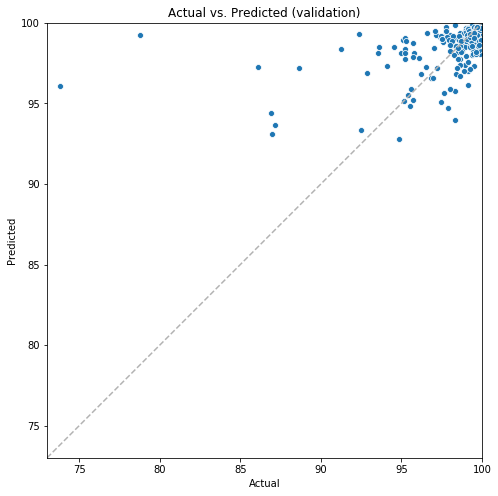

<Figure size 1080x1080 with 0 Axes>

In [233]:
y = df['actual gamma']
y_hat = df['predicted gamma']
display_scatterplot(ARG_PART, y, y_hat)

## Train an XGBoost model with extracted CNN features

In [234]:
df_features = pd.DataFrame(extracted_features)
df_result = pd.concat([df, df_features], axis=1)
df_result.head()

,filename,actual gamma,predicted gamma,0,1,2,3,4,5,6,...,502,503,504,505,506,507,508,509,510,511
0,/hdd/data/radioterapia/ciolaplata/2019/1.3.6.1...,94.971298,98.160515,0.188282,0.0,0.472093,0.193211,0.192909,0.0,0.000000,...,0.772296,0.260645,0.343846,0.169443,0.103001,0.216019,0.008451,0.046916,0.640380,0.001671
1,/hdd/data/radioterapia/ciolaplata/2019/1.3.6.1...,99.654182,99.648567,0.173830,0.0,0.485563,0.205866,0.197323,0.0,0.000000,...,0.777380,0.267690,0.331011,0.180557,0.085299,0.224983,0.000000,0.052339,0.641876,0.000457
2,/hdd/data/radioterapia/ciolaplata/2019/1.3.6.1...,95.114304,98.927109,0.168815,0.0,0.464255,0.213209,0.197604,0.0,0.000546,...,0.780857,0.264557,0.318286,0.176471,0.082935,0.220027,0.008618,0.042858,0.636962,0.001079
3,/hdd/data/radioterapia/ciolaplata/2019/1.3.6.1...,99.564850,99.463318,0.164420,0.0,0.475968,0.202276,0.194354,0.0,0.000000,...,0.781521,0.265057,0.332248,0.167891,0.080872,0.224488,0.000043,0.043115,0.639536,0.001982
4,/hdd/data/radioterapia/ciolaplata/2019/1.3.6.1...,99.814941,99.695999,0.170029,0.0,0.477014,0.208818,0.198810,0.0,0.000000,...,0.781630,0.265123,0.323269,0.181745,0.087322,0.225792,0.000047,0.041546,0.640906,0.000919


In [235]:
if isGoogleColab():
    drive.flush_and_unmount()
    print('All changes made in this colab session should now be visible in Drive.')